In [ ]:
# !pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap datasets langchain-community ragatouille

In [2]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)  # This will be helpful when visualizing retriever outputs

In [13]:
from dotenv import load_dotenv
from time import sleep
import os
import json

load_dotenv()  # take environment variables from .env.

True

In [6]:
# establish a connection to the PostgreSQL database
import psycopg2 as pg

conn = pg.connect(
    dbname=os.environ["POSTGRES_DB"],
    user=os.environ["POSTGRES_USER"],
    password=os.environ["POSTGRES_PASSWORD"],
    host=os.environ["POSTGRES_HOST"]
)

In [10]:
df = pd.read_sql_query(
    """SELECT
            fe.name as entity_name,
            fe.class as entity_class,
            fe.subclass as entity_subclass,
            fe.description as entity_description,

            fp.name as property_name,
            fp.parent as property_parent,
            fp.value as property_value,
            fp.description as property_description


    FROM fandom_properties fp left join fandom_entities fe on fp.object_id = fe.object_id;""",
      conn)

# id	object_id	name	value	description	parent	created_at	id	object_id	name	class	subclass	description	created_at

/tmp/ipykernel_455275/1609495954.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(


In [11]:
df.head()

,entity_name,entity_class,entity_subclass,entity_description,property_name,property_parent,property_value,property_description
0,Adam Holograd,character,lord,"Adam Holograd is the Lord Commander of the Holograd Empire, a prominent character in the game Bravely Default.",Home,Location,Holograd,The place where the character resides or is associated with.
1,Adam Holograd,character,lord,"Adam Holograd is the Lord Commander of the Holograd Empire, a prominent character in the game Bravely Default.",Affiliation,Affiliation,Holograd Empire,The faction or group the character is associated with.
2,Adam Holograd,character,lord,"Adam Holograd is the Lord Commander of the Holograd Empire, a prominent character in the game Bravely Default.",Occupation,Occupation,Lord Commander of the Holograd Empire,The role or job held by the character within their affiliated group.
3,Adam Holograd,character,lord,"Adam Holograd is the Lord Commander of the Holograd Empire, a prominent character in the game Bravely Default.",Race,Physical Description,Human,The species or race of the character.
4,Adam Holograd,character,lord,"Adam Holograd is the Lord Commander of the Holograd Empire, a prominent character in the game Bravely Default.",Gender,Physical Description,Male,The gender of the character.



## Embedding properties using HuggingFace model and local FAISS vector store

As described on HuggingFace tutorials here:   
"Advanced RAG on Hugging Face documentation using LangChain"   
https://huggingface.co/learn/cookbook/en/advanced_rag

In [14]:
from langchain.docstore.document import Document

RAW_KNOWLEDGE_BASE = [
    Document(page_content=json.dumps(doc), metadata={"entity_class": doc["entity_class"]}) for doc in tqdm(df.to_dict(orient="records"))
]

  0%|          | 0/38467 [00:00<?, ?it/s]

/home/aleksey/Workspace/GameOntologyProject/venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 512


  0%|          | 0/38467 [00:00<?, ?it/s]

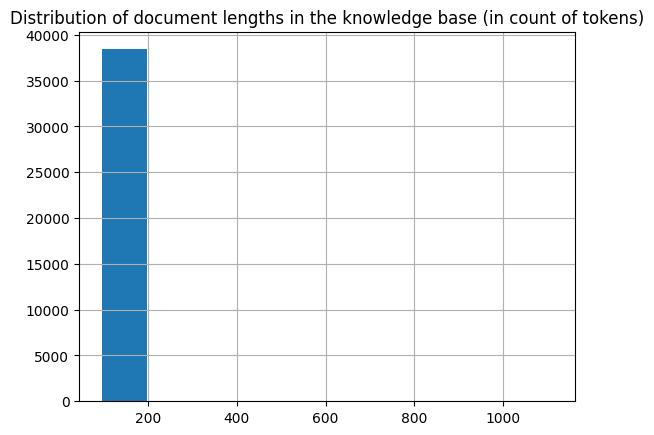

In [15]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}")

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(RAW_KNOWLEDGE_BASE)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [22]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

EMBEDDING_MODEL_NAME = "thenlper/gte-small"

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    RAW_KNOWLEDGE_BASE[:1000], embedding_model, distance_strategy=DistanceStrategy.COSINE
)

: 

## Project vector embeddings to 2D and vizualize using Plotly

In [20]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0]) for idx in range(len(RAW_KNOWLEDGE_BASE[:1000]))
]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

38467

In [ ]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "class": RAW_KNOWLEDGE_BASE[:1000][i].metadata["entity_class"],
            "extract": RAW_KNOWLEDGE_BASE[:1000][i].page_content[:100],
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(RAW_KNOWLEDGE_BASE[:1000]))
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()